# Sample Workflow for d3rlpy Experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
import subprocess
import os
import d3rlpy
plt.style.use('matplotlibrc')

from Python.data_sampler_confounder import *

## Building an MDPDataset

We first read in a large batch of samples from the file. As `d3rlpy` wants it in the form (observations, actions, rewards, terminal flags), we go ahead and do that. Here's a helper function to get a dataset from a list of chunks of your choosing.

In [38]:
def get_dataset(chunks : list, batch_size=30000, 
                path="collected_data/rl_det_small.txt") -> d3rlpy.dataset.MDPDataset :
    random.seed(0)
    samples = DataSampler(path_to_data=path)
    states = []
    actions = []
    rewards = []
    metrics = []
    next_states = []
    for chunk in chunks:
        samples.use_chunk(chunk)
        samples.read_chunk()
        [statesChunk, actionsChunk, rewardsChunk, nextStatesChunk, metricChunk] = samples.get_batch(batch_size)
        states.append(statesChunk)
        actions.append(actionsChunk)
        rewards.append(rewardsChunk)
        next_states.append(nextStatesChunk)
        metrics.append(metricChunk)
    states = torch.cat(states)
    actions = torch.cat(actions)
    rewards = torch.cat(rewards)
    next_states = torch.cat(next_states)
    metrics = np.hstack(metrics)
    
    terminals = np.zeros(len(states))
    terminals[::100] = 1 #episode length 100, change if necessary
    dataset = d3rlpy.dataset.MDPDataset(np.hstack([states.numpy(), metrics[:,None]]), 
                                        actions.numpy(), 
                                        rewards.numpy(), 
                                        metrics, terminals)
    return dataset, states.numpy(), actions.numpy(), rewards.numpy(), metrics

We can build the dataset from there, just like this, and split into train and test sets.

In [39]:
dataset, statesOrig, actions, rewards, metrics = get_dataset([3,5,7,9], path="collected_data/rl_det_small.txt")

Read chunk # 4 out of 10000
Read chunk # 6 out of 10000
Read chunk # 8 out of 10000
Read chunk # 10 out of 10000


In [41]:
print("The behavior policy value statistics are:")
dataset.compute_stats()['return']

The behavior policy value statistics are:


{'mean': -4.1227446,
 'std': 2.4676569,
 'min': -12.578855,
 'max': 0.0,
 'histogram': (array([ 26,   9,   7,   7,   8,   7,  10,  13,  27,  54,  56,  73, 109,
          84, 186, 148, 124,  83,  67,  13]),
  array([-12.578855 , -11.949912 , -11.320969 , -10.692026 , -10.063084 ,
          -9.434141 ,  -8.805199 ,  -8.176255 ,  -7.5473127,  -6.9183702,
          -6.2894273,  -5.6604843,  -5.031542 ,  -4.4025993,  -3.7736564,
          -3.1447136,  -2.515771 ,  -1.8868282,  -1.2578855,  -0.6289427,
           0.       ], dtype=float32))}

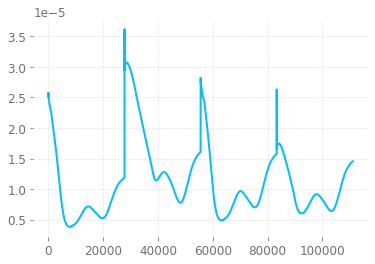

In [44]:
plt.plot(states[:,6])

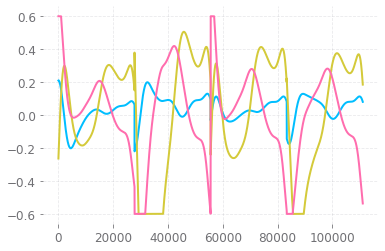

In [45]:
plt.plot(actions)

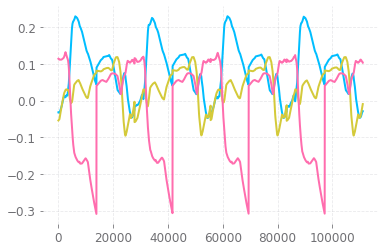

In [57]:
#plt.plot(model.predict(np.array(states)))

In [47]:
from sklearn.model_selection import train_test_split
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)

## Setting up an Algorithm

In [50]:
from d3rlpy.algos import CQL
from d3rlpy.models.encoders import VectorEncoderFactory

from d3rlpy.preprocessing import MinMaxActionScaler
action_scaler = MinMaxActionScaler(minimum=-0.6, maximum=0.6)
#cql = CQL(action_scaler=action_scaler)

#actor_encoder = VectorEncoderFactory(hidden_units=[12, 24, 36, 24, 12],
#                                       activation='relu', use_batch_norm=True, dropout_rate=0.2)
#critic_encoder = VectorEncoderFactory(hidden_units=[12, 24, 24, 12],
#                                       activation='relu', use_batch_norm=True, dropout_rate=0.2)

model = CQL(q_func_factory='mean', #qr -> quantile regression q function, but you don't have to use this
            reward_scaler='standard',
            action_scaler=action_scaler,
          actor_learning_rate=1e-5, 
          critic_learning_rate=0.0003, 
            use_gpu=False) #change it to true if you have one
model.build_with_dataset(dataset)

In [51]:
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer

# calculate metrics with test dataset
ave_error_init = average_value_estimation_scorer(model, test_episodes)
print(ave_error_init)

0.026841432688638055


In [8]:
%load_ext tensorboard
%tensorboard --logdir runs

In [52]:
model.fit(train_episodes,
        eval_episodes=test_episodes,
        n_epochs=5, 
        tensorboard_dir='runs',
        scorers={
            'td_error': td_error_scorer,
            'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer
        })

2022-04-14 11:21.01 [debug    ] RoundIterator is selected.
2022-04-14 11:21.01 [info     ] Directory is created at d3rlpy_logs/CQL_20220414112101
2022-04-14 11:21.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2022-04-14 11:21.01 [debug    ] Fitting reward scaler...       reward_scaler=standard
2022-04-14 11:21.01 [warning  ] Skip building models since they're already built.
2022-04-14 11:21.01 [info     ] Parameters are saved to d3rlpy_logs/CQL_20220414112101/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array(-0.6), 'maximum': array(0.6)}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [12, 24, 36, 24, 12], 'activation': 'relu', 'use_batch_norm': True, 'dropout_rate': 0.2, 'use_dense': False}}, 'actor_learning_rate': 1e-05, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls

Epoch 1/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-14 11:21.45 [info     ] CQL_20220414112101: epoch=1 step=343 epoch=1 metrics={'time_sample_batch': 0.0003742525250849154, 'time_algorithm_update': 0.12171427779573046, 'temp_loss': 2.802219798891607, 'temp': 0.9829186378345545, 'alpha_loss': -16.855045891364185, 'alpha': 1.0175056686901838, 'critic_loss': 31.779957234685693, 'actor_loss': 0.1835363066426693, 'time_step': 0.12217147218242679, 'td_error': 0.7099501222024098, 'init_value': 0.15456652641296387, 'ave_value': 0.15320690735713416} step=343
2022-04-14 11:21.45 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220414112101/model_343.pt


Epoch 2/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-14 11:22.29 [info     ] CQL_20220414112101: epoch=2 step=686 epoch=2 metrics={'time_sample_batch': 0.0003650251004855765, 'time_algorithm_update': 0.12206583398424155, 'temp_loss': 2.8902446778800677, 'temp': 0.9493256814278249, 'alpha_loss': -17.63308386621948, 'alpha': 1.053691466417674, 'critic_loss': 27.654098188216764, 'actor_loss': 0.203991379235863, 'time_step': 0.12251412277666543, 'td_error': 0.6763833473659171, 'init_value': 0.09563430398702621, 'ave_value': 0.09344399639375739} step=686
2022-04-14 11:22.29 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220414112101/model_686.pt


Epoch 3/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-14 11:23.13 [info     ] CQL_20220414112101: epoch=3 step=1029 epoch=3 metrics={'time_sample_batch': 0.0003632463449639412, 'time_algorithm_update': 0.12148242858686531, 'temp_loss': 2.9147486950843744, 'temp': 0.9168153610243394, 'alpha_loss': -18.695783520578992, 'alpha': 1.0921118492287727, 'critic_loss': 28.53143125928873, 'actor_loss': 0.23521700952712543, 'time_step': 0.12192847429837152, 'td_error': 0.6708724481406035, 'init_value': -0.07764415442943573, 'ave_value': -0.081524669555735} step=1029
2022-04-14 11:23.13 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220414112101/model_1029.pt


Epoch 4/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-14 11:23.58 [info     ] CQL_20220414112101: epoch=4 step=1372 epoch=4 metrics={'time_sample_batch': 0.0003725314626888353, 'time_algorithm_update': 0.1250987282299787, 'temp_loss': 2.9287689614921546, 'temp': 0.8855109244324375, 'alpha_loss': -19.618184965483998, 'alpha': 1.1327533051154357, 'critic_loss': 31.00726513542865, 'actor_loss': 0.39540615574654964, 'time_step': 0.1255544079983547, 'td_error': 0.8426468556791409, 'init_value': -0.4061134457588196, 'ave_value': -0.4119427143726254} step=1372
2022-04-14 11:23.58 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220414112101/model_1372.pt


Epoch 5/5:   0%|          | 0/343 [00:00<?, ?it/s]

2022-04-14 11:24.43 [info     ] CQL_20220414112101: epoch=5 step=1715 epoch=5 metrics={'time_sample_batch': 0.0003702411151140841, 'time_algorithm_update': 0.1246622352488882, 'temp_loss': 2.9286265811141656, 'temp': 0.8554273553561886, 'alpha_loss': -20.372496363025366, 'alpha': 1.175160357277873, 'critic_loss': 34.21237133126217, 'actor_loss': 0.6059260639869785, 'time_step': 0.1251168035557249, 'td_error': 0.8756173424689938, 'init_value': -0.6600608825683594, 'ave_value': -0.6677980384396115} step=1715
2022-04-14 11:24.43 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20220414112101/model_1715.pt


[(1,
  {'time_sample_batch': 0.0003742525250849154,
   'time_algorithm_update': 0.12171427779573046,
   'temp_loss': 2.802219798891607,
   'temp': 0.9829186378345545,
   'alpha_loss': -16.855045891364185,
   'alpha': 1.0175056686901838,
   'critic_loss': 31.779957234685693,
   'actor_loss': 0.1835363066426693,
   'time_step': 0.12217147218242679,
   'td_error': 0.7099501222024098,
   'init_value': 0.15456652641296387,
   'ave_value': 0.15320690735713416}),
 (2,
  {'time_sample_batch': 0.0003650251004855765,
   'time_algorithm_update': 0.12206583398424155,
   'temp_loss': 2.8902446778800677,
   'temp': 0.9493256814278249,
   'alpha_loss': -17.63308386621948,
   'alpha': 1.053691466417674,
   'critic_loss': 27.654098188216764,
   'actor_loss': 0.203991379235863,
   'time_step': 0.12251412277666543,
   'td_error': 0.6763833473659171,
   'init_value': 0.09563430398702621,
   'ave_value': 0.09344399639375739}),
 (3,
  {'time_sample_batch': 0.0003632463449639412,
   'time_algorithm_update': 

## Off-Policy Evaluation

We do get some metrics on a test set of initial state value and average value. However, these estimates (using the critic's Q-function) of model performance are biased. They're useful for validation during training, but not much else. Instead, we fit a Q-function to the data (or a separate dataset, as I've done here) separately and evaluate the model's performance on it.

Feel free to change the chunks and number of steps.

In [56]:
from d3rlpy.ope import FQE
# metrics to evaluate with
from d3rlpy.metrics.scorer import soft_opc_scorer


ope_dataset, states_ope, actions_ope, rewards_ope, metrics_ope = get_dataset([2,4,6,8], path="collected_data/rl_det_small.txt") #change if you'd prefer different chunks
ope_train_episodes, ope_test_episodes = train_test_split(ope_dataset, test_size=0.2)

fqe = FQE(algo=model, action_scaler = action_scaler, use_gpu=False) #change this if you have one!
fqe.fit(ope_train_episodes,
        eval_episodes=ope_test_episodes,
        tensorboard_dir='runs',
        n_epochs=50, n_steps_per_epoch=1000, #change if overfitting/underfitting
        scorers={
           'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer,
           'soft_opc': soft_opc_scorer(return_threshold=0)
        })

Read chunk # 3 out of 10000
Read chunk # 5 out of 10000
Read chunk # 7 out of 10000
Read chunk # 9 out of 10000
2022-04-14 11:28.07 [debug    ] RoundIterator is selected.
2022-04-14 11:28.07 [info     ] Directory is created at d3rlpy_logs/FQE_20220414112807
2022-04-14 11:28.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2022-04-14 11:28.07 [debug    ] Building models...
2022-04-14 11:28.07 [debug    ] Models have been built.
2022-04-14 11:28.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20220414112807/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array(-0.6), 'maximum': array(0.6)}}, 'batch_size': 100, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0

Epoch 1/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.10 [info     ] FQE_20220414112807: epoch=1 step=878 epoch=1 metrics={'time_sample_batch': 0.0001406897716478769, 'time_algorithm_update': 0.0025715200667500767, 'loss': 6.012114843727707e-05, 'time_step': 0.0027771248632791645, 'init_value': -0.1162392795085907, 'ave_value': -0.116274098765498, 'soft_opc': nan} step=878


2022-04-14 11:28.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_878.pt


Epoch 2/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.13 [info     ] FQE_20220414112807: epoch=2 step=1756 epoch=2 metrics={'time_sample_batch': 0.00013623829583100686, 'time_algorithm_update': 0.0025856484041670187, 'loss': 1.253738343991663e-05, 'time_step': 0.0027829870276136117, 'init_value': -0.22958892583847046, 'ave_value': -0.2296075281728549, 'soft_opc': nan} step=1756


2022-04-14 11:28.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_1756.pt


Epoch 3/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.16 [info     ] FQE_20220414112807: epoch=3 step=2634 epoch=3 metrics={'time_sample_batch': 0.00013488110214268157, 'time_algorithm_update': 0.0025936275516935795, 'loss': 1.1151875288697564e-05, 'time_step': 0.002790888784143539, 'init_value': -0.33581387996673584, 'ave_value': -0.3358338916153775, 'soft_opc': nan} step=2634


2022-04-14 11:28.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_2634.pt


Epoch 4/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.19 [info     ] FQE_20220414112807: epoch=4 step=3512 epoch=4 metrics={'time_sample_batch': 0.00013183135378062047, 'time_algorithm_update': 0.0025116457754495746, 'loss': 9.212168055315577e-06, 'time_step': 0.002704294504500196, 'init_value': -0.4338066875934601, 'ave_value': -0.4338276424193915, 'soft_opc': nan} step=3512


2022-04-14 11:28.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_3512.pt


Epoch 5/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.22 [info     ] FQE_20220414112807: epoch=5 step=4390 epoch=5 metrics={'time_sample_batch': 0.00012971898689356914, 'time_algorithm_update': 0.0025096246484743435, 'loss': 7.735069096055107e-06, 'time_step': 0.0027007000321407795, 'init_value': -0.5041369795799255, 'ave_value': -0.5041536978687795, 'soft_opc': nan} step=4390


2022-04-14 11:28.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_4390.pt


Epoch 6/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.24 [info     ] FQE_20220414112807: epoch=6 step=5268 epoch=6 metrics={'time_sample_batch': 0.0001278379783543476, 'time_algorithm_update': 0.0024285213279289647, 'loss': 7.437800466427046e-06, 'time_step': 0.0026146988119242673, 'init_value': -0.5838014483451843, 'ave_value': -0.5838200756484802, 'soft_opc': nan} step=5268


2022-04-14 11:28.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_5268.pt


Epoch 7/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.27 [info     ] FQE_20220414112807: epoch=7 step=6146 epoch=7 metrics={'time_sample_batch': 0.00012635071348220722, 'time_algorithm_update': 0.0024092990336494185, 'loss': 6.202607077179795e-06, 'time_step': 0.0025939406457957483, 'init_value': -0.6553435325622559, 'ave_value': -0.6553642220345292, 'soft_opc': nan} step=6146


2022-04-14 11:28.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_6146.pt


Epoch 8/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.30 [info     ] FQE_20220414112807: epoch=8 step=7024 epoch=8 metrics={'time_sample_batch': 0.0001311598171677296, 'time_algorithm_update': 0.0024848350902896264, 'loss': 5.26992566724822e-06, 'time_step': 0.0026759484905859877, 'init_value': -0.7159742712974548, 'ave_value': -0.7160016178960584, 'soft_opc': nan} step=7024


2022-04-14 11:28.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_7024.pt


Epoch 9/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.33 [info     ] FQE_20220414112807: epoch=9 step=7902 epoch=9 metrics={'time_sample_batch': 0.00013068732476723222, 'time_algorithm_update': 0.0024635854234456474, 'loss': 4.615822577989417e-06, 'time_step': 0.0026546037821671958, 'init_value': -0.7775982618331909, 'ave_value': -0.7776289718298073, 'soft_opc': nan} step=7902


2022-04-14 11:28.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_7902.pt


Epoch 10/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.36 [info     ] FQE_20220414112807: epoch=10 step=8780 epoch=10 metrics={'time_sample_batch': 0.00012878893719718776, 'time_algorithm_update': 0.0024672070505407243, 'loss': 5.155354439189886e-06, 'time_step': 0.002655436889457268, 'init_value': -0.8197927474975586, 'ave_value': -0.8198203928699451, 'soft_opc': nan} step=8780


2022-04-14 11:28.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_8780.pt


Epoch 11/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.39 [info     ] FQE_20220414112807: epoch=11 step=9658 epoch=11 metrics={'time_sample_batch': 0.0001310960035389268, 'time_algorithm_update': 0.0024889362700164725, 'loss': 4.04110786305201e-06, 'time_step': 0.0026823982834001336, 'init_value': -0.8672283291816711, 'ave_value': -0.867263688761757, 'soft_opc': nan} step=9658


2022-04-14 11:28.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_9658.pt


Epoch 12/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.42 [info     ] FQE_20220414112807: epoch=12 step=10536 epoch=12 metrics={'time_sample_batch': 0.00012986860948706, 'time_algorithm_update': 0.002485617146676657, 'loss': 4.234541573168567e-06, 'time_step': 0.0026750944741494565, 'init_value': -0.9100000858306885, 'ave_value': -0.9100329721460482, 'soft_opc': nan} step=10536


2022-04-14 11:28.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_10536.pt


Epoch 13/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.45 [info     ] FQE_20220414112807: epoch=13 step=11414 epoch=13 metrics={'time_sample_batch': 0.0001341348900067236, 'time_algorithm_update': 0.0025760280244171213, 'loss': 4.118177385347293e-06, 'time_step': 0.0027744794489310922, 'init_value': -0.9497425556182861, 'ave_value': -0.9497842380964556, 'soft_opc': nan} step=11414


2022-04-14 11:28.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_11414.pt


Epoch 14/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.48 [info     ] FQE_20220414112807: epoch=14 step=12292 epoch=14 metrics={'time_sample_batch': 0.00012862220712023064, 'time_algorithm_update': 0.0025142420397261007, 'loss': 3.7805792403847642e-06, 'time_step': 0.002702682327844016, 'init_value': -0.9787203669548035, 'ave_value': -0.9787687507072923, 'soft_opc': nan} step=12292


2022-04-14 11:28.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_12292.pt


Epoch 15/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.50 [info     ] FQE_20220414112807: epoch=15 step=13170 epoch=15 metrics={'time_sample_batch': 0.0001280948621536985, 'time_algorithm_update': 0.002445571243355649, 'loss': 4.079657701491635e-06, 'time_step': 0.0026336829591720686, 'init_value': -1.0168523788452148, 'ave_value': -1.0169046974033098, 'soft_opc': nan} step=13170


2022-04-14 11:28.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_13170.pt


Epoch 16/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.53 [info     ] FQE_20220414112807: epoch=16 step=14048 epoch=16 metrics={'time_sample_batch': 0.0001264313630471197, 'time_algorithm_update': 0.002427888894135425, 'loss': 4.174827207662574e-06, 'time_step': 0.002612392017129885, 'init_value': -1.0443687438964844, 'ave_value': -1.0444261869313132, 'soft_opc': nan} step=14048


2022-04-14 11:28.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_14048.pt


Epoch 17/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.56 [info     ] FQE_20220414112807: epoch=17 step=14926 epoch=17 metrics={'time_sample_batch': 0.0001293366482154655, 'time_algorithm_update': 0.0024900574890519057, 'loss': 5.088929877140706e-06, 'time_step': 0.0026795812511226855, 'init_value': -1.0697559118270874, 'ave_value': -1.0698182487226446, 'soft_opc': nan} step=14926


2022-04-14 11:28.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_14926.pt


Epoch 18/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.59 [info     ] FQE_20220414112807: epoch=18 step=15804 epoch=18 metrics={'time_sample_batch': 0.00012878595017626508, 'time_algorithm_update': 0.00248173293328774, 'loss': 4.580442235397547e-06, 'time_step': 0.0026699027602384738, 'init_value': -1.0892751216888428, 'ave_value': -1.0893393486080791, 'soft_opc': nan} step=15804


2022-04-14 11:28.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_15804.pt


Epoch 19/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.02 [info     ] FQE_20220414112807: epoch=19 step=16682 epoch=19 metrics={'time_sample_batch': 0.00012657854171440106, 'time_algorithm_update': 0.0024290388971906587, 'loss': 4.015657292352247e-06, 'time_step': 0.0026156712230082798, 'init_value': -1.1037254333496094, 'ave_value': -1.10379683916868, 'soft_opc': nan} step=16682


2022-04-14 11:29.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_16682.pt


Epoch 20/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.05 [info     ] FQE_20220414112807: epoch=20 step=17560 epoch=20 metrics={'time_sample_batch': 0.0001307888834786035, 'time_algorithm_update': 0.0024790446144573237, 'loss': 3.97442127971383e-06, 'time_step': 0.002669869903008324, 'init_value': -1.1169019937515259, 'ave_value': -1.116975453812807, 'soft_opc': nan} step=17560


2022-04-14 11:29.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_17560.pt


Epoch 21/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.08 [info     ] FQE_20220414112807: epoch=21 step=18438 epoch=21 metrics={'time_sample_batch': 0.0001303907950538166, 'time_algorithm_update': 0.0025059316044244787, 'loss': 5.55189597050444e-06, 'time_step': 0.0026974200116203152, 'init_value': -1.1340217590332031, 'ave_value': -1.134097831120832, 'soft_opc': nan} step=18438


2022-04-14 11:29.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_18438.pt


Epoch 22/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.11 [info     ] FQE_20220414112807: epoch=22 step=19316 epoch=22 metrics={'time_sample_batch': 0.00012976868005982835, 'time_algorithm_update': 0.00249336873751838, 'loss': 5.077585877424912e-06, 'time_step': 0.002682886797094671, 'init_value': -1.149480938911438, 'ave_value': -1.1495647299423075, 'soft_opc': nan} step=19316


2022-04-14 11:29.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_19316.pt


Epoch 23/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.13 [info     ] FQE_20220414112807: epoch=23 step=20194 epoch=23 metrics={'time_sample_batch': 0.00012838596091998194, 'time_algorithm_update': 0.0024739585324680615, 'loss': 6.2205342567141264e-06, 'time_step': 0.00266291964841595, 'init_value': -1.159434199333191, 'ave_value': -1.1595185035142355, 'soft_opc': nan} step=20194


2022-04-14 11:29.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_20194.pt


Epoch 24/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.16 [info     ] FQE_20220414112807: epoch=24 step=21072 epoch=24 metrics={'time_sample_batch': 0.00013034463200319328, 'time_algorithm_update': 0.0024149792612549385, 'loss': 5.148960908588965e-06, 'time_step': 0.0026047631656933483, 'init_value': -1.1790404319763184, 'ave_value': -1.179122918514031, 'soft_opc': nan} step=21072


2022-04-14 11:29.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_21072.pt


Epoch 25/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.19 [info     ] FQE_20220414112807: epoch=25 step=21950 epoch=25 metrics={'time_sample_batch': 0.00012944879727374447, 'time_algorithm_update': 0.0023924267101939557, 'loss': 5.32755766783843e-06, 'time_step': 0.0025816686061085766, 'init_value': -1.1822208166122437, 'ave_value': -1.1822966122997678, 'soft_opc': nan} step=21950


2022-04-14 11:29.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_21950.pt


Epoch 26/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.22 [info     ] FQE_20220414112807: epoch=26 step=22828 epoch=26 metrics={'time_sample_batch': 0.00013088989909526157, 'time_algorithm_update': 0.0024481351934967388, 'loss': 4.722591220997399e-06, 'time_step': 0.0026384950498785135, 'init_value': -1.1839449405670166, 'ave_value': -1.1840191116236678, 'soft_opc': nan} step=22828


2022-04-14 11:29.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_22828.pt


Epoch 27/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.25 [info     ] FQE_20220414112807: epoch=27 step=23706 epoch=27 metrics={'time_sample_batch': 0.0001295628471635197, 'time_algorithm_update': 0.002410583995740886, 'loss': 5.4228844444297965e-06, 'time_step': 0.0026004936266054053, 'init_value': -1.1889424324035645, 'ave_value': -1.1890155213809117, 'soft_opc': nan} step=23706


2022-04-14 11:29.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_23706.pt


Epoch 28/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.28 [info     ] FQE_20220414112807: epoch=28 step=24584 epoch=28 metrics={'time_sample_batch': 0.00012936000128813377, 'time_algorithm_update': 0.0023694339808679114, 'loss': 3.8576525656658155e-06, 'time_step': 0.0025565599797798453, 'init_value': -1.192555546760559, 'ave_value': -1.1926276850820252, 'soft_opc': nan} step=24584


2022-04-14 11:29.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_24584.pt


Epoch 29/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.30 [info     ] FQE_20220414112807: epoch=29 step=25462 epoch=29 metrics={'time_sample_batch': 0.00012962421686611307, 'time_algorithm_update': 0.002405877265408805, 'loss': 4.660067280506189e-06, 'time_step': 0.0025944872706245995, 'init_value': -1.1940412521362305, 'ave_value': -1.1941076467481813, 'soft_opc': nan} step=25462


2022-04-14 11:29.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_25462.pt


Epoch 30/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.33 [info     ] FQE_20220414112807: epoch=30 step=26340 epoch=30 metrics={'time_sample_batch': 0.00013076607350064845, 'time_algorithm_update': 0.0024585688575796765, 'loss': 4.250556603753974e-06, 'time_step': 0.002649407995045864, 'init_value': -1.2016905546188354, 'ave_value': -1.2017535481347323, 'soft_opc': nan} step=26340


2022-04-14 11:29.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_26340.pt


Epoch 31/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.36 [info     ] FQE_20220414112807: epoch=31 step=27218 epoch=31 metrics={'time_sample_batch': 0.00012908872547888266, 'time_algorithm_update': 0.0024704400933684956, 'loss': 4.891096205359582e-06, 'time_step': 0.002660292156193414, 'init_value': -1.2039355039596558, 'ave_value': -1.2039971453947946, 'soft_opc': nan} step=27218


2022-04-14 11:29.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_27218.pt


Epoch 32/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.39 [info     ] FQE_20220414112807: epoch=32 step=28096 epoch=32 metrics={'time_sample_batch': 0.00013267803843852329, 'time_algorithm_update': 0.002566718294843183, 'loss': 4.493854757362584e-06, 'time_step': 0.0027623084248605784, 'init_value': -1.2094646692276, 'ave_value': -1.2095289473225415, 'soft_opc': nan} step=28096


2022-04-14 11:29.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_28096.pt


Epoch 33/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.42 [info     ] FQE_20220414112807: epoch=33 step=28974 epoch=33 metrics={'time_sample_batch': 0.0001307962152572319, 'time_algorithm_update': 0.002506320460239141, 'loss': 5.211403350601241e-06, 'time_step': 0.0026989268279021313, 'init_value': -1.214996576309204, 'ave_value': -1.2150604109479644, 'soft_opc': nan} step=28974


2022-04-14 11:29.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_28974.pt


Epoch 34/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.45 [info     ] FQE_20220414112807: epoch=34 step=29852 epoch=34 metrics={'time_sample_batch': 0.0001301692124108247, 'time_algorithm_update': 0.002489951857130185, 'loss': 4.989992615744261e-06, 'time_step': 0.0026805992821626076, 'init_value': -1.218166708946228, 'ave_value': -1.2182340487171603, 'soft_opc': nan} step=29852


2022-04-14 11:29.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_29852.pt


Epoch 35/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.48 [info     ] FQE_20220414112807: epoch=35 step=30730 epoch=35 metrics={'time_sample_batch': 0.0001283427848902813, 'time_algorithm_update': 0.0024803567312844522, 'loss': 5.526398686641347e-06, 'time_step': 0.0026679709723435663, 'init_value': -1.221823811531067, 'ave_value': -1.2218935127064343, 'soft_opc': nan} step=30730


2022-04-14 11:29.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_30730.pt


Epoch 36/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.51 [info     ] FQE_20220414112807: epoch=36 step=31608 epoch=36 metrics={'time_sample_batch': 0.0001305985287816215, 'time_algorithm_update': 0.002480778444329264, 'loss': 5.066323903219775e-06, 'time_step': 0.002671646908909965, 'init_value': -1.2284133434295654, 'ave_value': -1.2284829240781152, 'soft_opc': nan} step=31608


2022-04-14 11:29.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_31608.pt


Epoch 37/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.53 [info     ] FQE_20220414112807: epoch=37 step=32486 epoch=37 metrics={'time_sample_batch': 0.00013093551905117166, 'time_algorithm_update': 0.00250356126754865, 'loss': 7.090061591473535e-06, 'time_step': 0.0026951688840340373, 'init_value': -1.234350323677063, 'ave_value': -1.2344255641453097, 'soft_opc': nan} step=32486


2022-04-14 11:29.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_32486.pt


Epoch 38/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.56 [info     ] FQE_20220414112807: epoch=38 step=33364 epoch=38 metrics={'time_sample_batch': 0.0001292660459027475, 'time_algorithm_update': 0.002458839318746858, 'loss': 6.182027864053998e-06, 'time_step': 0.0026477444959392854, 'init_value': -1.2432106733322144, 'ave_value': -1.2432806605407605, 'soft_opc': nan} step=33364


2022-04-14 11:29.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_33364.pt


Epoch 39/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:29.59 [info     ] FQE_20220414112807: epoch=39 step=34242 epoch=39 metrics={'time_sample_batch': 0.0001273584257225784, 'time_algorithm_update': 0.0024222097527193316, 'loss': 7.050809256514841e-06, 'time_step': 0.002608325595464685, 'init_value': -1.2522547245025635, 'ave_value': -1.252323791072189, 'soft_opc': nan} step=34242


2022-04-14 11:29.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_34242.pt


Epoch 40/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.02 [info     ] FQE_20220414112807: epoch=40 step=35120 epoch=40 metrics={'time_sample_batch': 0.00012744314849784, 'time_algorithm_update': 0.002438723090569359, 'loss': 7.296935949854412e-06, 'time_step': 0.0026255411547788997, 'init_value': -1.2674921751022339, 'ave_value': -1.2675518690257335, 'soft_opc': nan} step=35120


2022-04-14 11:30.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_35120.pt


Epoch 41/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.05 [info     ] FQE_20220414112807: epoch=41 step=35998 epoch=41 metrics={'time_sample_batch': 0.00013129097454097114, 'time_algorithm_update': 0.00249014682813223, 'loss': 7.727761371920352e-06, 'time_step': 0.0026825758753713552, 'init_value': -1.2742810249328613, 'ave_value': -1.2743490772974764, 'soft_opc': nan} step=35998


2022-04-14 11:30.05 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_35998.pt


Epoch 42/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.08 [info     ] FQE_20220414112807: epoch=42 step=36876 epoch=42 metrics={'time_sample_batch': 0.000132464330668873, 'time_algorithm_update': 0.002539305046098922, 'loss': 8.319126329777429e-06, 'time_step': 0.00273428745313223, 'init_value': -1.2834999561309814, 'ave_value': -1.2835640640164185, 'soft_opc': nan} step=36876


2022-04-14 11:30.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_36876.pt


Epoch 43/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.11 [info     ] FQE_20220414112807: epoch=43 step=37754 epoch=43 metrics={'time_sample_batch': 0.00012897847725209995, 'time_algorithm_update': 0.0024968494315353775, 'loss': 7.990087820200605e-06, 'time_step': 0.0026858053880834906, 'init_value': -1.297984004020691, 'ave_value': -1.2980521591146954, 'soft_opc': nan} step=37754


2022-04-14 11:30.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_37754.pt


Epoch 44/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.14 [info     ] FQE_20220414112807: epoch=44 step=38632 epoch=44 metrics={'time_sample_batch': 0.00012969862084182357, 'time_algorithm_update': 0.002474125534092375, 'loss': 9.954452634521432e-06, 'time_step': 0.0026639382225505854, 'init_value': -1.3083409070968628, 'ave_value': -1.308406101543359, 'soft_opc': nan} step=38632


2022-04-14 11:30.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_38632.pt


Epoch 45/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.17 [info     ] FQE_20220414112807: epoch=45 step=39510 epoch=45 metrics={'time_sample_batch': 0.00013174011386880028, 'time_algorithm_update': 0.002488420330038918, 'loss': 8.270843102314155e-06, 'time_step': 0.0026816952472938763, 'init_value': -1.316685438156128, 'ave_value': -1.3167468677284375, 'soft_opc': nan} step=39510


2022-04-14 11:30.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_39510.pt


Epoch 46/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.19 [info     ] FQE_20220414112807: epoch=46 step=40388 epoch=46 metrics={'time_sample_batch': 0.00012832513431210182, 'time_algorithm_update': 0.0024732351303100586, 'loss': 8.979957455385488e-06, 'time_step': 0.002660960705785382, 'init_value': -1.3167943954467773, 'ave_value': -1.3168548134437326, 'soft_opc': nan} step=40388


2022-04-14 11:30.19 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_40388.pt


Epoch 47/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.22 [info     ] FQE_20220414112807: epoch=47 step=41266 epoch=47 metrics={'time_sample_batch': 0.0001290371314811272, 'time_algorithm_update': 0.002473759488255668, 'loss': 9.17013808841517e-06, 'time_step': 0.0026638434525231296, 'init_value': -1.3308806419372559, 'ave_value': -1.3309457017745034, 'soft_opc': nan} step=41266


2022-04-14 11:30.22 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_41266.pt


Epoch 48/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.25 [info     ] FQE_20220414112807: epoch=48 step=42144 epoch=48 metrics={'time_sample_batch': 0.00012708579217654426, 'time_algorithm_update': 0.0024085487483031113, 'loss': 8.893393937130774e-06, 'time_step': 0.0025944880852666694, 'init_value': -1.3458776473999023, 'ave_value': -1.3459463144237485, 'soft_opc': nan} step=42144


2022-04-14 11:30.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_42144.pt


Epoch 49/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.28 [info     ] FQE_20220414112807: epoch=49 step=43022 epoch=49 metrics={'time_sample_batch': 0.00012728103472594519, 'time_algorithm_update': 0.002422594535323645, 'loss': 1.0284846415124008e-05, 'time_step': 0.00260906800593765, 'init_value': -1.351300597190857, 'ave_value': -1.3513712895954897, 'soft_opc': nan} step=43022


2022-04-14 11:30.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_43022.pt


Epoch 50/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:30.31 [info     ] FQE_20220414112807: epoch=50 step=43900 epoch=50 metrics={'time_sample_batch': 0.00013448627228617395, 'time_algorithm_update': 0.002567017811577521, 'loss': 1.0449550548717675e-05, 'time_step': 0.002764446317199151, 'init_value': -1.3617901802062988, 'ave_value': -1.3618684665779976, 'soft_opc': nan} step=43900


2022-04-14 11:30.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112807/model_43900.pt


[(1,
  {'time_sample_batch': 0.0001406897716478769,
   'time_algorithm_update': 0.0025715200667500767,
   'loss': 6.012114843727707e-05,
   'time_step': 0.0027771248632791645,
   'init_value': -0.1162392795085907,
   'ave_value': -0.116274098765498,
   'soft_opc': nan}),
 (2,
  {'time_sample_batch': 0.00013623829583100686,
   'time_algorithm_update': 0.0025856484041670187,
   'loss': 1.253738343991663e-05,
   'time_step': 0.0027829870276136117,
   'init_value': -0.22958892583847046,
   'ave_value': -0.2296075281728549,
   'soft_opc': nan}),
 (3,
  {'time_sample_batch': 0.00013488110214268157,
   'time_algorithm_update': 0.0025936275516935795,
   'loss': 1.1151875288697564e-05,
   'time_step': 0.002790888784143539,
   'init_value': -0.33581387996673584,
   'ave_value': -0.3358338916153775,
   'soft_opc': nan}),
 (4,
  {'time_sample_batch': 0.00013183135378062047,
   'time_algorithm_update': 0.0025116457754495746,
   'loss': 9.212168055315577e-06,
   'time_step': 0.002704294504500196,
  

In [55]:
from d3rlpy.ope import FQE
# metrics to evaluate with
from d3rlpy.metrics.scorer import soft_opc_scorer


ope_dataset, states_ope, actions_ope, rewards_ope, metrics_ope = get_dataset([2,4,6,8], path="collected_data/rl_stoch_small.txt") #change if you'd prefer different chunks
ope_train_episodes, ope_test_episodes = train_test_split(ope_dataset, test_size=0.2)

fqe = FQE(algo=model, action_scaler = action_scaler, use_gpu=False) #change this if you have one!
fqe.fit(ope_train_episodes, eval_episodes=ope_test_episodes,
        tensorboard_dir='runs',
        n_epochs=50, n_steps_per_epoch=1000, #change if overfitting/underfitting
        scorers={
           'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer,
           'soft_opc': soft_opc_scorer(return_threshold=0)
        })

Read chunk # 3 out of 10000
Read chunk # 5 out of 10000
Read chunk # 7 out of 10000
Read chunk # 9 out of 10000
2022-04-14 11:25.43 [debug    ] RoundIterator is selected.
2022-04-14 11:25.43 [info     ] Directory is created at d3rlpy_logs/FQE_20220414112543
2022-04-14 11:25.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2022-04-14 11:25.43 [debug    ] Building models...
2022-04-14 11:25.43 [debug    ] Models have been built.
2022-04-14 11:25.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20220414112543/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array(-0.6), 'maximum': array(0.6)}}, 'batch_size': 100, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0

Epoch 1/50:   0%|          | 0/878 [00:00<?, ?it/s]

/Users/hetankevin/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hetankevin/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2022-04-14 11:25.46 [info     ] FQE_20220414112543: epoch=1 step=878 epoch=1 metrics={'time_sample_batch': 0.00013588392653063382, 'time_algorithm_update': 0.0024935191747539405, 'loss': 0.00024350237326829704, 'time_step': 0.002690095836317892, 'init_value': -0.3430844843387604, 'ave_value': -0.34485272273340967, 'soft_opc': nan} step=878


2022-04-14 11:25.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_878.pt


Epoch 2/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:25.49 [info     ] FQE_20220414112543: epoch=2 step=1756 epoch=2 metrics={'time_sample_batch': 0.00013110550769640807, 'time_algorithm_update': 0.0026946461553725674, 'loss': 4.625578038430499e-05, 'time_step': 0.0028868359693905218, 'init_value': -0.40856030583381653, 'ave_value': -0.41155371763669, 'soft_opc': nan} step=1756


2022-04-14 11:25.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_1756.pt


Epoch 3/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:25.51 [info     ] FQE_20220414112543: epoch=3 step=2634 epoch=3 metrics={'time_sample_batch': 0.00012768020934015851, 'time_algorithm_update': 0.0024152703600212218, 'loss': 3.825276002905343e-05, 'time_step': 0.002601289260360266, 'init_value': -0.46184131503105164, 'ave_value': -0.46575748969561115, 'soft_opc': nan} step=2634


2022-04-14 11:25.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_2634.pt


Epoch 4/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:25.54 [info     ] FQE_20220414112543: epoch=4 step=3512 epoch=4 metrics={'time_sample_batch': 0.00012953324850164947, 'time_algorithm_update': 0.0024721239585268197, 'loss': 4.081331813481142e-05, 'time_step': 0.0026614087589237846, 'init_value': -0.5090494155883789, 'ave_value': -0.5136469942458308, 'soft_opc': nan} step=3512


2022-04-14 11:25.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_3512.pt


Epoch 5/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:25.57 [info     ] FQE_20220414112543: epoch=5 step=4390 epoch=5 metrics={'time_sample_batch': 0.00012753004365195447, 'time_algorithm_update': 0.002437657267194674, 'loss': 4.843612827169632e-05, 'time_step': 0.00262158036503542, 'init_value': -0.5484934449195862, 'ave_value': -0.5534969001178909, 'soft_opc': nan} step=4390


2022-04-14 11:25.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_4390.pt


Epoch 6/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.00 [info     ] FQE_20220414112543: epoch=6 step=5268 epoch=6 metrics={'time_sample_batch': 0.00012763350319482198, 'time_algorithm_update': 0.002474406042511751, 'loss': 5.120846964776968e-05, 'time_step': 0.0026617601412032353, 'init_value': -0.5737336874008179, 'ave_value': -0.5790478128964082, 'soft_opc': nan} step=5268


2022-04-14 11:26.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_5268.pt


Epoch 7/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.03 [info     ] FQE_20220414112543: epoch=7 step=6146 epoch=7 metrics={'time_sample_batch': 0.0001291242981825983, 'time_algorithm_update': 0.0024844942983570837, 'loss': 5.161093711720258e-05, 'time_step': 0.00267426571161709, 'init_value': -0.6043100953102112, 'ave_value': -0.6096492676222061, 'soft_opc': nan} step=6146


2022-04-14 11:26.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_6146.pt


Epoch 8/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.06 [info     ] FQE_20220414112543: epoch=8 step=7024 epoch=8 metrics={'time_sample_batch': 0.00012710344275472377, 'time_algorithm_update': 0.0024705709791943806, 'loss': 5.387467360382794e-05, 'time_step': 0.002657315182522924, 'init_value': -0.6391584873199463, 'ave_value': -0.6446553121659271, 'soft_opc': nan} step=7024


2022-04-14 11:26.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_7024.pt


Epoch 9/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.09 [info     ] FQE_20220414112543: epoch=9 step=7902 epoch=9 metrics={'time_sample_batch': 0.00012663909677492459, 'time_algorithm_update': 0.002427276283298918, 'loss': 5.1925340024523594e-05, 'time_step': 0.0026127724549764924, 'init_value': -0.6805837750434875, 'ave_value': -0.6862557593248955, 'soft_opc': nan} step=7902


2022-04-14 11:26.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_7902.pt


Epoch 10/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.12 [info     ] FQE_20220414112543: epoch=10 step=8780 epoch=10 metrics={'time_sample_batch': 0.00012807531074402273, 'time_algorithm_update': 0.002429237398308339, 'loss': 5.6761615421106844e-05, 'time_step': 0.002616424766922866, 'init_value': -0.7084238529205322, 'ave_value': -0.7140924466336238, 'soft_opc': nan} step=8780


2022-04-14 11:26.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_8780.pt


Epoch 11/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.14 [info     ] FQE_20220414112543: epoch=11 step=9658 epoch=11 metrics={'time_sample_batch': 0.00012596701706732053, 'time_algorithm_update': 0.00247124903294383, 'loss': 5.239316617822429e-05, 'time_step': 0.0026554713759715572, 'init_value': -0.714576780796051, 'ave_value': -0.7201773106787601, 'soft_opc': nan} step=9658


2022-04-14 11:26.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_9658.pt


Epoch 12/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.17 [info     ] FQE_20220414112543: epoch=12 step=10536 epoch=12 metrics={'time_sample_batch': 0.00012695463480330273, 'time_algorithm_update': 0.0024105981162034296, 'loss': 5.8102270729327107e-05, 'time_step': 0.0025941882969849747, 'init_value': -0.7274693846702576, 'ave_value': -0.7330493298764826, 'soft_opc': nan} step=10536


2022-04-14 11:26.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_10536.pt


Epoch 13/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.20 [info     ] FQE_20220414112543: epoch=13 step=11414 epoch=13 metrics={'time_sample_batch': 0.00012561644942993998, 'time_algorithm_update': 0.002430405866583822, 'loss': 5.301281941626841e-05, 'time_step': 0.0026150599699085557, 'init_value': -0.7325389981269836, 'ave_value': -0.7380436159628252, 'soft_opc': nan} step=11414


2022-04-14 11:26.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_11414.pt


Epoch 14/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.23 [info     ] FQE_20220414112543: epoch=14 step=12292 epoch=14 metrics={'time_sample_batch': 0.00012622444396138464, 'time_algorithm_update': 0.002425888676306653, 'loss': 5.0084391651996936e-05, 'time_step': 0.0026080426431190993, 'init_value': -0.7467763423919678, 'ave_value': -0.7521841132696726, 'soft_opc': nan} step=12292


2022-04-14 11:26.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_12292.pt


Epoch 15/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.26 [info     ] FQE_20220414112543: epoch=15 step=13170 epoch=15 metrics={'time_sample_batch': 0.0001309436654718699, 'time_algorithm_update': 0.002469859525120068, 'loss': 5.082587643118108e-05, 'time_step': 0.002662493047518719, 'init_value': -0.7404713034629822, 'ave_value': -0.7455486805340342, 'soft_opc': nan} step=13170


2022-04-14 11:26.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_13170.pt


Epoch 16/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.29 [info     ] FQE_20220414112543: epoch=16 step=14048 epoch=16 metrics={'time_sample_batch': 0.00012639144558569836, 'time_algorithm_update': 0.002388391516474765, 'loss': 4.0502811001042804e-05, 'time_step': 0.0025739333081082495, 'init_value': -0.7523947358131409, 'ave_value': -0.7572245010499932, 'soft_opc': nan} step=14048


2022-04-14 11:26.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_14048.pt


Epoch 17/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.31 [info     ] FQE_20220414112543: epoch=17 step=14926 epoch=17 metrics={'time_sample_batch': 0.00012660814037627132, 'time_algorithm_update': 0.0024671016901663604, 'loss': 4.212971019360536e-05, 'time_step': 0.0026530790437598434, 'init_value': -0.7632788419723511, 'ave_value': -0.7680822734670341, 'soft_opc': nan} step=14926


2022-04-14 11:26.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_14926.pt


Epoch 18/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.34 [info     ] FQE_20220414112543: epoch=18 step=15804 epoch=18 metrics={'time_sample_batch': 0.00012774076440068204, 'time_algorithm_update': 0.002434460883260045, 'loss': 3.807545657262542e-05, 'time_step': 0.0026219252301783115, 'init_value': -0.7887688875198364, 'ave_value': -0.7935814776892312, 'soft_opc': nan} step=15804


2022-04-14 11:26.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_15804.pt


Epoch 19/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.37 [info     ] FQE_20220414112543: epoch=19 step=16682 epoch=19 metrics={'time_sample_batch': 0.00013039188124324303, 'time_algorithm_update': 0.0024819659209197095, 'loss': 3.9038147537477015e-05, 'time_step': 0.0026742961249210297, 'init_value': -0.8133786916732788, 'ave_value': -0.8182383614894342, 'soft_opc': nan} step=16682


2022-04-14 11:26.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_16682.pt


Epoch 20/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.40 [info     ] FQE_20220414112543: epoch=20 step=17560 epoch=20 metrics={'time_sample_batch': 0.00012677215497966236, 'time_algorithm_update': 0.002466798100221673, 'loss': 4.267156348578645e-05, 'time_step': 0.002650302200491173, 'init_value': -0.8215645551681519, 'ave_value': -0.8263368593695836, 'soft_opc': nan} step=17560


2022-04-14 11:26.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_17560.pt


Epoch 21/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.43 [info     ] FQE_20220414112543: epoch=21 step=18438 epoch=21 metrics={'time_sample_batch': 0.00012767396375095653, 'time_algorithm_update': 0.002425071047215907, 'loss': 3.803825324564799e-05, 'time_step': 0.002613219693472825, 'init_value': -0.8413321375846863, 'ave_value': -0.8459605484905248, 'soft_opc': nan} step=18438


2022-04-14 11:26.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_18438.pt


Epoch 22/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.46 [info     ] FQE_20220414112543: epoch=22 step=19316 epoch=22 metrics={'time_sample_batch': 0.00012863741377220066, 'time_algorithm_update': 0.00248361964432145, 'loss': 3.635865717763394e-05, 'time_step': 0.0026725633812385158, 'init_value': -0.860020637512207, 'ave_value': -0.864559080664509, 'soft_opc': nan} step=19316


2022-04-14 11:26.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_19316.pt


Epoch 23/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.49 [info     ] FQE_20220414112543: epoch=23 step=20194 epoch=23 metrics={'time_sample_batch': 0.00012878242006062919, 'time_algorithm_update': 0.0024745399153585585, 'loss': 3.69567267393143e-05, 'time_step': 0.0026623961051124106, 'init_value': -0.8679266571998596, 'ave_value': -0.8724417067588701, 'soft_opc': nan} step=20194


2022-04-14 11:26.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_20194.pt


Epoch 24/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.51 [info     ] FQE_20220414112543: epoch=24 step=21072 epoch=24 metrics={'time_sample_batch': 0.00012471952851106474, 'time_algorithm_update': 0.002421953955109407, 'loss': 3.180411238527231e-05, 'time_step': 0.002599497047806655, 'init_value': -0.862248420715332, 'ave_value': -0.866761784771244, 'soft_opc': nan} step=21072


2022-04-14 11:26.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_21072.pt


Epoch 25/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.54 [info     ] FQE_20220414112543: epoch=25 step=21950 epoch=25 metrics={'time_sample_batch': 0.00012827761352469548, 'time_algorithm_update': 0.0024624666483364236, 'loss': 3.480251597236159e-05, 'time_step': 0.002652495216943137, 'init_value': -0.8749518394470215, 'ave_value': -0.8794423811579439, 'soft_opc': nan} step=21950


2022-04-14 11:26.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_21950.pt


Epoch 26/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:26.57 [info     ] FQE_20220414112543: epoch=26 step=22828 epoch=26 metrics={'time_sample_batch': 0.000124256268720692, 'time_algorithm_update': 0.002409969484072883, 'loss': 3.46780889982667e-05, 'time_step': 0.0025903640955618683, 'init_value': -0.8684371709823608, 'ave_value': -0.8730087652907087, 'soft_opc': nan} step=22828


2022-04-14 11:26.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_22828.pt


Epoch 27/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.00 [info     ] FQE_20220414112543: epoch=27 step=23706 epoch=27 metrics={'time_sample_batch': 0.00013069954439827957, 'time_algorithm_update': 0.0024909261690456938, 'loss': 3.656210092031644e-05, 'time_step': 0.0026837481453098307, 'init_value': -0.8799434900283813, 'ave_value': -0.884541834595951, 'soft_opc': nan} step=23706


2022-04-14 11:27.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_23706.pt


Epoch 28/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.03 [info     ] FQE_20220414112543: epoch=28 step=24584 epoch=28 metrics={'time_sample_batch': 0.00012795311443354927, 'time_algorithm_update': 0.0024644022378943232, 'loss': 3.7807223273249856e-05, 'time_step': 0.0026520615558146346, 'init_value': -0.8817962408065796, 'ave_value': -0.8863760993946352, 'soft_opc': nan} step=24584


2022-04-14 11:27.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_24584.pt


Epoch 29/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.06 [info     ] FQE_20220414112543: epoch=29 step=25462 epoch=29 metrics={'time_sample_batch': 0.00012707438718756673, 'time_algorithm_update': 0.002390235594573488, 'loss': 3.393902720956304e-05, 'time_step': 0.0025745527076286717, 'init_value': -0.8844600915908813, 'ave_value': -0.889069959953945, 'soft_opc': nan} step=25462


2022-04-14 11:27.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_25462.pt


Epoch 30/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.08 [info     ] FQE_20220414112543: epoch=30 step=26340 epoch=30 metrics={'time_sample_batch': 0.0001270515772096117, 'time_algorithm_update': 0.0024561925466620024, 'loss': 3.4266075065281966e-05, 'time_step': 0.002642961460799997, 'init_value': -0.8787535429000854, 'ave_value': -0.8833520067187924, 'soft_opc': nan} step=26340


2022-04-14 11:27.08 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_26340.pt


Epoch 31/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.11 [info     ] FQE_20220414112543: epoch=31 step=27218 epoch=31 metrics={'time_sample_batch': 0.00013006629596267038, 'time_algorithm_update': 0.002436105917146374, 'loss': 3.6118269475495136e-05, 'time_step': 0.0026267465534948816, 'init_value': -0.8944056034088135, 'ave_value': -0.8989871552890424, 'soft_opc': nan} step=27218


2022-04-14 11:27.11 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_27218.pt


Epoch 32/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.14 [info     ] FQE_20220414112543: epoch=32 step=28096 epoch=32 metrics={'time_sample_batch': 0.00013066587252606022, 'time_algorithm_update': 0.0024861708317367795, 'loss': 3.648916020413921e-05, 'time_step': 0.002674400399105967, 'init_value': -0.9015170335769653, 'ave_value': -0.9060983949218501, 'soft_opc': nan} step=28096


2022-04-14 11:27.14 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_28096.pt


Epoch 33/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.17 [info     ] FQE_20220414112543: epoch=33 step=28974 epoch=33 metrics={'time_sample_batch': 0.00012991531563239653, 'time_algorithm_update': 0.0024754121254679825, 'loss': 3.389012151447841e-05, 'time_step': 0.002666660213253221, 'init_value': -0.9049625992774963, 'ave_value': -0.9094908090612295, 'soft_opc': nan} step=28974


2022-04-14 11:27.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_28974.pt


Epoch 34/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.20 [info     ] FQE_20220414112543: epoch=34 step=29852 epoch=34 metrics={'time_sample_batch': 0.00012735380941751606, 'time_algorithm_update': 0.0024446933307517363, 'loss': 3.25336101766896e-05, 'time_step': 0.0026307410151105806, 'init_value': -0.909135103225708, 'ave_value': -0.9136692918450654, 'soft_opc': nan} step=29852


2022-04-14 11:27.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_29852.pt


Epoch 35/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.23 [info     ] FQE_20220414112543: epoch=35 step=30730 epoch=35 metrics={'time_sample_batch': 0.00013102512967885218, 'time_algorithm_update': 0.0024647362411429506, 'loss': 3.308722371082939e-05, 'time_step': 0.0026535281830876727, 'init_value': -0.9253649711608887, 'ave_value': -0.9296925841787347, 'soft_opc': nan} step=30730


2022-04-14 11:27.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_30730.pt


Epoch 36/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.26 [info     ] FQE_20220414112543: epoch=36 step=31608 epoch=36 metrics={'time_sample_batch': 0.0001319380718917673, 'time_algorithm_update': 0.0024177688672493694, 'loss': 3.175856825589329e-05, 'time_step': 0.0026101384456173977, 'init_value': -0.9218503832817078, 'ave_value': -0.9262549017101719, 'soft_opc': nan} step=31608


2022-04-14 11:27.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_31608.pt


Epoch 37/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.28 [info     ] FQE_20220414112543: epoch=37 step=32486 epoch=37 metrics={'time_sample_batch': 0.00012867515885476915, 'time_algorithm_update': 0.002334792684585467, 'loss': 3.0812796379879816e-05, 'time_step': 0.0025215062030627135, 'init_value': -0.930402934551239, 'ave_value': -0.9348970779694092, 'soft_opc': nan} step=32486


2022-04-14 11:27.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_32486.pt


Epoch 38/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.31 [info     ] FQE_20220414112543: epoch=38 step=33364 epoch=38 metrics={'time_sample_batch': 0.00012808943120656632, 'time_algorithm_update': 0.0023722735515759583, 'loss': 3.3377289811074115e-05, 'time_step': 0.002560502847397789, 'init_value': -0.9275195002555847, 'ave_value': -0.9320544448458058, 'soft_opc': nan} step=33364


2022-04-14 11:27.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_33364.pt


Epoch 39/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.34 [info     ] FQE_20220414112543: epoch=39 step=34242 epoch=39 metrics={'time_sample_batch': 0.00012593361674245778, 'time_algorithm_update': 0.002409704996947547, 'loss': 3.271333514990981e-05, 'time_step': 0.0025949263627002344, 'init_value': -0.9299391508102417, 'ave_value': -0.9343820439209761, 'soft_opc': nan} step=34242


2022-04-14 11:27.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_34242.pt


Epoch 40/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.37 [info     ] FQE_20220414112543: epoch=40 step=35120 epoch=40 metrics={'time_sample_batch': 0.00013016595384254543, 'time_algorithm_update': 0.002484276788924441, 'loss': 3.502875252741962e-05, 'time_step': 0.002673452155736693, 'init_value': -0.9331858158111572, 'ave_value': -0.937626905755169, 'soft_opc': nan} step=35120


2022-04-14 11:27.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_35120.pt


Epoch 41/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.40 [info     ] FQE_20220414112543: epoch=41 step=35998 epoch=41 metrics={'time_sample_batch': 0.00012795610145447195, 'time_algorithm_update': 0.0025284716643070577, 'loss': 2.908535698703466e-05, 'time_step': 0.002705522170099419, 'init_value': -0.9519885182380676, 'ave_value': -0.9565204287879886, 'soft_opc': nan} step=35998


2022-04-14 11:27.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_35998.pt


Epoch 42/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.43 [info     ] FQE_20220414112543: epoch=42 step=36876 epoch=42 metrics={'time_sample_batch': 0.00012938362590815864, 'time_algorithm_update': 0.002463322022509738, 'loss': 3.251647396612618e-05, 'time_step': 0.0026547534047606865, 'init_value': -0.921057939529419, 'ave_value': -0.925589825304143, 'soft_opc': nan} step=36876


2022-04-14 11:27.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_36876.pt


Epoch 43/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.45 [info     ] FQE_20220414112543: epoch=43 step=37754 epoch=43 metrics={'time_sample_batch': 0.00013164805931491027, 'time_algorithm_update': 0.0024978462818814845, 'loss': 3.4723115876294365e-05, 'time_step': 0.0026935268371686303, 'init_value': -0.9113733768463135, 'ave_value': -0.9157840770826168, 'soft_opc': nan} step=37754


2022-04-14 11:27.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_37754.pt


Epoch 44/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.48 [info     ] FQE_20220414112543: epoch=44 step=38632 epoch=44 metrics={'time_sample_batch': 0.00013103273300483722, 'time_algorithm_update': 0.002525669295586866, 'loss': 3.048781181647896e-05, 'time_step': 0.002720277238815412, 'init_value': -0.9139968752861023, 'ave_value': -0.9185085225368251, 'soft_opc': nan} step=38632


2022-04-14 11:27.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_38632.pt


Epoch 45/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.51 [info     ] FQE_20220414112543: epoch=45 step=39510 epoch=45 metrics={'time_sample_batch': 0.00013167711488206729, 'time_algorithm_update': 0.002536937696244016, 'loss': 3.270478294848441e-05, 'time_step': 0.0027325465630290177, 'init_value': -0.9194219708442688, 'ave_value': -0.9239324822022268, 'soft_opc': nan} step=39510


2022-04-14 11:27.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_39510.pt


Epoch 46/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.54 [info     ] FQE_20220414112543: epoch=46 step=40388 epoch=46 metrics={'time_sample_batch': 0.0001307508668486784, 'time_algorithm_update': 0.002527022687612199, 'loss': 3.158219099218031e-05, 'time_step': 0.002719657567747633, 'init_value': -0.9237528443336487, 'ave_value': -0.9283087190434505, 'soft_opc': nan} step=40388


2022-04-14 11:27.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_40388.pt


Epoch 47/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:27.57 [info     ] FQE_20220414112543: epoch=47 step=41266 epoch=47 metrics={'time_sample_batch': 0.00013049425459668414, 'time_algorithm_update': 0.0026459294734077193, 'loss': 3.369135793059856e-05, 'time_step': 0.002834002357952144, 'init_value': -0.9200228452682495, 'ave_value': -0.924578982318674, 'soft_opc': nan} step=41266


2022-04-14 11:27.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_41266.pt


Epoch 48/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.00 [info     ] FQE_20220414112543: epoch=48 step=42144 epoch=48 metrics={'time_sample_batch': 0.00012742848494058317, 'time_algorithm_update': 0.002446222685464151, 'loss': 3.065055072827513e-05, 'time_step': 0.00263568725021119, 'init_value': -0.9139971137046814, 'ave_value': -0.9185340703249183, 'soft_opc': nan} step=42144


2022-04-14 11:28.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_42144.pt


Epoch 49/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.03 [info     ] FQE_20220414112543: epoch=49 step=43022 epoch=49 metrics={'time_sample_batch': 0.00013116144645186926, 'time_algorithm_update': 0.0025023640152533667, 'loss': 3.259389973552314e-05, 'time_step': 0.0026966216623918885, 'init_value': -0.9193013310432434, 'ave_value': -0.923844203209161, 'soft_opc': nan} step=43022


2022-04-14 11:28.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_43022.pt


Epoch 50/50:   0%|          | 0/878 [00:00<?, ?it/s]

2022-04-14 11:28.06 [info     ] FQE_20220414112543: epoch=50 step=43900 epoch=50 metrics={'time_sample_batch': 0.00012961226878242232, 'time_algorithm_update': 0.002496544755401264, 'loss': 3.3068466632092296e-05, 'time_step': 0.0026892513240388423, 'init_value': -0.9241190552711487, 'ave_value': -0.928644247289293, 'soft_opc': nan} step=43900


2022-04-14 11:28.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20220414112543/model_43900.pt


[(1,
  {'time_sample_batch': 0.00013588392653063382,
   'time_algorithm_update': 0.0024935191747539405,
   'loss': 0.00024350237326829704,
   'time_step': 0.002690095836317892,
   'init_value': -0.3430844843387604,
   'ave_value': -0.34485272273340967,
   'soft_opc': nan}),
 (2,
  {'time_sample_batch': 0.00013110550769640807,
   'time_algorithm_update': 0.0026946461553725674,
   'loss': 4.625578038430499e-05,
   'time_step': 0.0028868359693905218,
   'init_value': -0.40856030583381653,
   'ave_value': -0.41155371763669,
   'soft_opc': nan}),
 (3,
  {'time_sample_batch': 0.00012768020934015851,
   'time_algorithm_update': 0.0024152703600212218,
   'loss': 3.825276002905343e-05,
   'time_step': 0.002601289260360266,
   'init_value': -0.46184131503105164,
   'ave_value': -0.46575748969561115,
   'soft_opc': nan}),
 (4,
  {'time_sample_batch': 0.00012953324850164947,
   'time_algorithm_update': 0.0024721239585268197,
   'loss': 4.081331813481142e-05,
   'time_step': 0.0026614087589237846,
